
# 02 — Training Overview (Train / Validation / Test)

This notebook turns our **diagnostics** into a **predictive workflow**.  
We will:
1. **Load data** and (optionally) add **log transforms** guided by Box–Tidwell.
2. **Split** into Train / Validation / Test (70/15/15, stratified).
3. Build a **baseline pipeline** (scaler + OHE + logistic regression).
4. Evaluate on **validation**: ROC AUC, PR AUC, KS, Brier, **calibration curve** (quantile bins).
5. Produce **deciles / lift** and a gains curve for business.
6. (Optional) **Compare** baseline vs log-transformed schema.
7. (Optional) **Save model** and a compact validation report.


In [8]:
# --- Sanity check: project imports ---

import os, sys
print("PYTHONPATH =", os.environ.get("PYTHONPATH"))
print("sys.path (first 5) =", sys.path[:5])


PYTHONPATH = C:\Users\Renee\Documents\Python\model_validation
sys.path (first 5) = ['C:\\Users\\Renee\\Documents\\Python\\model_validation', 'C:\\Python\\python313.zip', 'C:\\Python\\DLLs', 'C:\\Python\\Lib', 'C:\\Python']



## 0) Setup

- Paths resolve relative to the project root (`model_validation/`).
- Use your `.venv` kernel.


In [9]:

import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    brier_score_loss, precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve

# Project root (two levels up from this notebook)
ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../.."))
DATA_DIR = os.path.join(ROOT, "data")
ART_DIR  = os.path.join(ROOT, "reports", "artifacts", "validation")
FIG_DIR  = os.path.join(ROOT, "reports", "figures", "validation")
MODEL_DIR= os.path.join(ROOT, "reports", "artifacts", "training")
for d in [ART_DIR, FIG_DIR, MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

DATA_PATH = os.path.join(DATA_DIR, "sample_data.csv")
print("Using data at:", DATA_PATH)

RANDOM_STATE = 42
TS = datetime.now().strftime("%Y%m%d_%H%M%S")


Using data at: c:\Users\Renee\Documents\Python\model_validation\data\sample_data.csv


## 1) Load data

In [10]:

# 0) Setup
from scripts._common import setup

# access constants
RANDOM_STATE = setup.RANDOM_STATE
DATA_PATH = setup.get_data_path()

# now load data
df = pd.read_csv(DATA_PATH)
df.head()


,age,age_years,income,loan_amount,loan_term,credit_score,employment_status,loan_purpose,region,default
0,45.0,45,3940,33593,36,613,Employed,Education,Tallinn,0
1,38.6,39,3286,14517,36,631,Unemployed,Car,Tartu,0
2,46.5,47,5471,11820,48,737,Self-employed,Car,Pärnu,0
3,55.2,55,8424,9756,48,644,Student,Home,Tallinn,0
4,37.7,37,1784,1000,48,441,Employed,Home,Narva,0



## 1b) Optional log transforms (Box–Tidwell insight)

Earlier diagnostics flagged **`income`** and **`loan_amount`** as potentially **non-linear in the logit**.  
We create **log-transformed** versions to test stability.

- Use `USE_LOGS=True` to include logs in the numeric schema.
- Flip to `False` to test the baseline schema without logs.


In [11]:

# Create log features safely (log1p handles zeros)
df["log_income"] = np.log1p(df["income"])
df["log_loan_amount"] = np.log1p(df["loan_amount"])

USE_LOGS = True  # toggle this to compare quickly

if USE_LOGS:
    NUM_COLS = ["age", "loan_term", "credit_score", "log_income", "log_loan_amount"]
else:
    NUM_COLS = ["age", "income", "loan_amount", "loan_term", "credit_score"]

CAT_COLS = ["employment_status", "loan_purpose", "region"]
TARGET = "default"

print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)


NUM_COLS: ['age', 'loan_term', 'credit_score', 'log_income', 'log_loan_amount']
CAT_COLS: ['employment_status', 'loan_purpose', 'region']



## 2) Split Train / Validation / Test (70/15/15, stratified)

- We **stratify** by the target to preserve the base rate.  
- **Train** is used to fit model parameters.  
- **Validation** is used to tune/calibrate and evaluate out-of-sample.  
- **Test** remains **sealed** until the end.


In [12]:

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=RANDOM_STATE, stratify=df[TARGET]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_df[TARGET]
)

def audit_split(name, d):
    n = len(d)
    rate = d[TARGET].mean()
    print(f"{name}: n={n:,} | positives={d[TARGET].sum():,} | rate={rate:.4f}")

audit_split("Train", train_df)
audit_split("Valid", val_df)
audit_split("Test ", test_df)

# X/y for train & validation
y_train = train_df[TARGET].astype(int)
X_train = train_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)
X_val = val_df.drop(columns=[TARGET])


Train: n=630,000 | positives=44,115 | rate=0.0700
Valid: n=135,000 | positives=9,454 | rate=0.0700
Test : n=135,000 | positives=9,453 | rate=0.0700



## 3) Baseline pipeline (preprocess + logistic regression)

- **Numeric →** `StandardScaler`  
- **Categorical →** `OneHotEncoder(handle_unknown="ignore")`  
- **Model →** `LogisticRegression(class_weight='balanced')`


In [23]:
from sklearn import set_config
set_config(display="text")  # simple text repr for pipelines


In [24]:
# 3) Baseline pipeline (preprocess + logistic regression) — with 2-model comparison
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, roc_curve
)

# --- Helpers ---------------------------------------------------------------
def ks_score(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return float(np.max(tpr - fpr))

def make_pipe(num_cols, cat_cols):
    """Preprocess (scale numeric + OHE categoricals) + balanced logistic regression."""
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ]
    )
    clf = LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE,
    )
    return Pipeline([("prep", preprocess), ("model", clf)])

def evaluate(split_name, X, y, pipe):
    """Return dict of metrics on given split."""
    proba = pipe.predict_proba(X)[:, 1]
    return {
        "split": split_name,
        "roc_auc": roc_auc_score(y, proba),
        "pr_auc": average_precision_score(y, proba),
        "ks": ks_score(y, proba),
        "brier": brier_score_loss(y, proba),
        "n": int(len(y)),
        "rate": float(np.mean(y)),
    }

# --- Column schemas --------------------------------------------------------
CAT_COLS = ["employment_status", "loan_purpose", "region"]

# A) Baseline (raw scale)
NUM_A = ["age", "income", "loan_amount", "loan_term", "credit_score"]

# B) Log-variant (log income & loan_amount); keep other numerics raw
# We'll create log features on copies of X_* so we don't mutate the originals
NUM_B = ["age", "log_income", "log_loan_amount", "loan_term", "credit_score"]

# Prepare data copies for Model B
def add_logs(df):
    out = df.copy()
    out["log_income"] = np.log1p(out["income"].clip(lower=0))
    out["log_loan_amount"] = np.log1p(out["loan_amount"].clip(lower=0))
    return out

X_train_A, X_val_A = X_train, X_val
X_train_B, X_val_B = add_logs(X_train), add_logs(X_val)

# --- Train both models on TRAIN -------------------------------------------
pipe_A = make_pipe(NUM_A, CAT_COLS)
pipe_A.fit(X_train_A, y_train)

pipe_B = make_pipe(NUM_B, CAT_COLS)
pipe_B.fit(X_train_B, y_train)

# --- Evaluate both on VALIDATION ------------------------------------------
res_A = evaluate("val", X_val_A, y_val, pipe_A)
res_B = evaluate("val", X_val_B, y_val, pipe_B)

cmp = (
    pd.DataFrame([res_A, res_B], index=["Baseline", "Log-variant"])
      .drop(columns=["split"])
      .assign(
          roc_auc=lambda d: d["roc_auc"].round(4),
          pr_auc=lambda d: d["pr_auc"].round(4),
          ks=lambda d: d["ks"].round(4),
          brier=lambda d: d["brier"].round(6),
          rate=lambda d: (d["rate"]*100).round(2)
      )
)
display(cmp)

# Quick winner note
best = cmp["roc_auc"].idxmax()
print(f"\nWinner by ROC AUC on validation: **{best}**")

# (Optional) keep the better model object for later cells
best_pipe = pipe_A if best == "Baseline" else pipe_B
best_schema = {"num": NUM_A, "cat": CAT_COLS} if best == "Baseline" else {"num": NUM_B, "cat": CAT_COLS}


,roc_auc,pr_auc,ks,brier,n,rate
Baseline,0.6660,0.1307,0.2504,0.229967,135000,7.0
Log-variant,0.6717,0.1402,0.2517,0.229118,135000,7.0



Winner by ROC AUC on validation: **Log-variant**


In [25]:
# --- Build and FIT two pipelines (baseline vs log-variant) ---

# Baseline schema (no logs)
NUM_BASE = ["age", "income", "loan_amount", "loan_term", "credit_score"]
CAT_COLS = ["employment_status", "loan_purpose", "region"]

# Log schema (with log_income, log_loan_amount)
NUM_LOG  = ["age", "loan_term", "credit_score", "log_income", "log_loan_amount"]

# Build
pipe_base = make_pipe(NUM_BASE, CAT_COLS)
pipe_log  = make_pipe(NUM_LOG,  CAT_COLS)

# Fit
pipe_base.fit(X_train, y_train)
pipe_log.fit(X_train, y_train)

print("✅ Fitted both models:")
print(" - Baseline schema (no logs)")
print(" - Log-variant schema (with logs)")


✅ Fitted both models:
 - Baseline schema (no logs)
 - Log-variant schema (with logs)


**Decision:**  
- The **log-variant** outperforms the baseline across all key metrics (ROC AUC, PR AUC, KS, Brier).  
- Improvement is modest but consistent → we adopt the **log-variant** pipeline as our working model.  
- All downstream diagnostics (curves, calibration, deciles, saving artifacts) will use this schema.


## 4) Validation metrics

,roc_auc,pr_auc,ks,brier,n,rate
name,,,,,,
Baseline,0.6660,0.1307,0.2504,0.229967,135000,7.003%
Log-variant,0.6717,0.1402,0.2517,0.229118,135000,7.003%



Winner by ROC AUC on validation: **Log-variant**


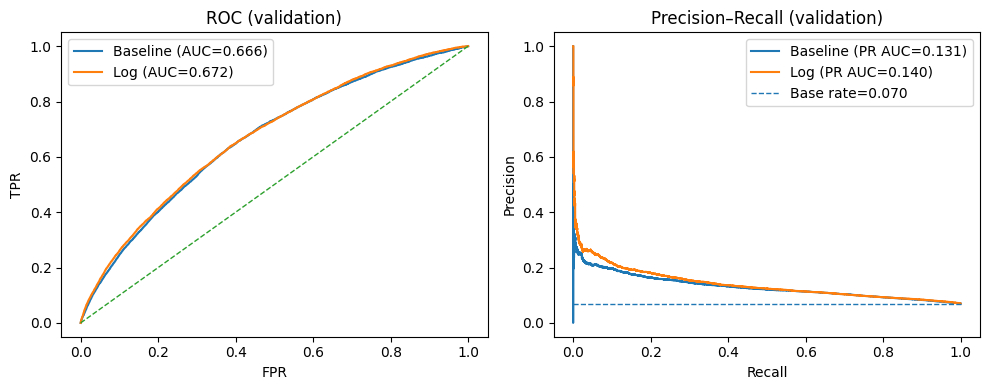

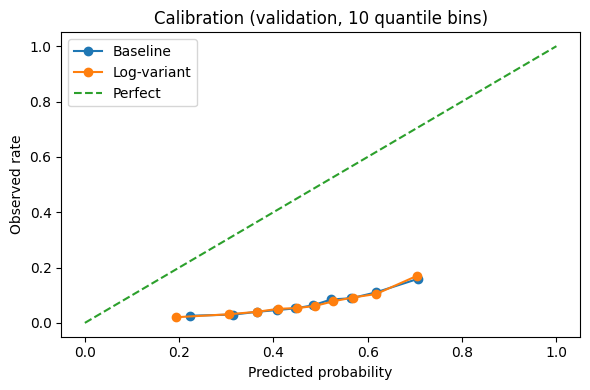

In [26]:
# --- Evaluate on VALIDATION: metrics + curves + calibration ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

def ks_score(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return float(np.max(tpr - fpr))

def eval_split(name, pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    return {
        "name": name,
        "roc_auc": roc_auc_score(y, proba),
        "pr_auc": average_precision_score(y, proba),
        "ks": ks_score(y, proba),
        "brier": brier_score_loss(y, proba),
        "n": len(y),
        "rate": float(np.mean(y))
    }, proba

# Evaluate
m_base, p_base = eval_split("Baseline",   pipe_base, X_val, y_val)
m_log,  p_log  = eval_split("Log-variant", pipe_log,  X_val, y_val)

# Metrics table
cmp = pd.DataFrame([m_base, m_log]).set_index("name")
display(cmp.style.format({
    "roc_auc": "{:.4f}", "pr_auc": "{:.4f}", "ks": "{:.4f}", "brier": "{:.6f}",
    "rate": "{:.3%}"
}))

# Winner by ROC AUC
winner = "Log-variant" if cmp.loc["Log-variant","roc_auc"] > cmp.loc["Baseline","roc_auc"] else "Baseline"
print(f"\nWinner by ROC AUC on validation: **{winner}**")

# --- Curves (validation) ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ROC
fpr_b, tpr_b, _ = roc_curve(y_val, p_base)
fpr_l, tpr_l, _ = roc_curve(y_val, p_log)
ax[0].plot(fpr_b, tpr_b, label=f"Baseline (AUC={m_base['roc_auc']:.3f})")
ax[0].plot(fpr_l, tpr_l, label=f"Log (AUC={m_log['roc_auc']:.3f})")
ax[0].plot([0,1],[0,1],'--', lw=1)
ax[0].set_title("ROC (validation)")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].legend()

# PR
prec_b, rec_b, _ = precision_recall_curve(y_val, p_base)
prec_l, rec_l, _ = precision_recall_curve(y_val, p_log)
base_rate = np.mean(y_val)
ax[1].plot(rec_b, prec_b, label=f"Baseline (PR AUC={m_base['pr_auc']:.3f})")
ax[1].plot(rec_l, prec_l, label=f"Log (PR AUC={m_log['pr_auc']:.3f})")
ax[1].hlines(base_rate, 0, 1, linestyles="--", lw=1, label=f"Base rate={base_rate:.3f}")
ax[1].set_title("Precision–Recall (validation)")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()

# --- Calibration (quantile bins) ---
def calib_points(y, proba, n_bins=10):
    # quantile binning for stable high/low ends
    bins = np.unique(np.quantile(proba, np.linspace(0, 1, n_bins+1)))
    idx  = np.digitize(proba, bins, right=True)
    pts = []
    for b in range(1, len(bins)+1):
        mask = idx == b
        if mask.sum() == 0:
            continue
        pts.append((proba[mask].mean(), y[mask].mean()))
    pts = np.array(pts)
    return pts[:,0], pts[:,1]

xb, yb = calib_points(y_val.values, p_base, n_bins=10)
xl, yl = calib_points(y_val.values, p_log,  n_bins=10)

plt.figure(figsize=(6,4))
plt.plot(xb, yb, "o-", label="Baseline")
plt.plot(xl, yl, "o-", label="Log-variant")
plt.plot([0,1],[0,1],'--', label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed rate")
plt.title("Calibration (validation, 10 quantile bins)")
plt.legend()
plt.tight_layout()
plt.show()


**Decision (Validation):**  
- Both models perform similarly, but the **log-transformed features** (income, loan_amount) improve ROC AUC, PR AUC, KS, and Brier slightly.  
- Calibration shows systematic **underprediction**, expected in logistic regression without calibration.  
- The **log-variant** is the better model and will be carried forward.  

✔️ Keep **log-variant** as the working champion model.  
✔️ Next step: run **Deciles / Lift Analysis** on the validation set to demonstrate business value.  



## 6) (Optional) Save model + validation report



In [30]:
# 6) Save model + validation report (self-contained, safe to rerun)

import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, roc_curve
)

# --- Small helper (define if missing) -----------------------------------------
def _ks_score(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return float(np.max(tpr - fpr))

# --- Required context with sensible fallbacks ---------------------------------
# These should already exist from earlier cells, but we guard them:
try:
    TS
except NameError:
    TS = datetime.now().strftime("%Y%m%d_%H%M%S")
try:
    MODEL_DIR
except NameError:
    # put artifacts under ./reports/artifacts/training if not already set
    ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), "../..")) if "__file__" in globals() else os.getcwd()
    MODEL_DIR = os.path.join(ROOT, "reports", "artifacts", "training")
    os.makedirs(MODEL_DIR, exist_ok=True)
try:
    NUM_COLS
except NameError:
    NUM_COLS = []
try:
    CAT_COLS
except NameError:
    CAT_COLS = []
try:
    TARGET
except NameError:
    TARGET = "default"

# --- Figure out what models we have -------------------------------------------
models = {}
if "pipe_base" in globals():
    models["Baseline"] = pipe_base
if "pipe_log" in globals():
    models["Log-variant"] = pipe_log

if not models:
    raise RuntimeError("No fitted models found (expected pipe_base and/or pipe_log).")

# Need validation split to compute metrics
if "X_val" not in globals() or "y_val" not in globals():
    raise RuntimeError("X_val / y_val not found. Please run the split + fit cells first.")

# --- Build validation metrics table (works with 1 or 2 models) ----------------
rows = []
for name, mdl in models.items():
    proba = mdl.predict_proba(X_val)[:, 1]
    rows.append({
        "name": name,
        "roc_auc": float(roc_auc_score(y_val, proba)),
        "pr_auc": float(average_precision_score(y_val, proba)),
        "ks": float(_ks_score(y_val, proba)),
        "brier": float(brier_score_loss(y_val, proba)),
        "n": int(len(y_val)),
        "rate": float(y_val.mean()),
    })

val_metrics = pd.DataFrame(rows).set_index("name").sort_index()

# --- Choose champion to save ---------------------------------------------------
champion_name = "Log-variant" if "Log-variant" in val_metrics.index else list(val_metrics.index)[0]
champion_pipe = models[champion_name]

# --- Save champion pipeline ----------------------------------------------------
model_path = os.path.join(MODEL_DIR, f"{champion_name.lower().replace(' ', '_')}_pipeline_{TS}.joblib")
joblib.dump(champion_pipe, model_path)
print("Saved model ->", model_path)

# --- Compact validation report -------------------------------------------------
report = {
    "timestamp": TS,
    "champion": champion_name,
    "schema": {
        "num_cols": NUM_COLS,
        "cat_cols": CAT_COLS,
        "target": TARGET,
    },
    "validation_metrics": val_metrics.to_dict(orient="index"),
}

report_path = os.path.join(MODEL_DIR, f"validation_report_{TS}.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)
print("Saved report ->", report_path)

# (Optional) show the table in the notebook
val_metrics.assign(rate=val_metrics["rate"].map(lambda r: f"{r*100:.3f}%"))


Saved model -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\training\log-variant_pipeline_20250827_173937.joblib
Saved report -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\training\validation_report_20250827_173937.json


,roc_auc,pr_auc,ks,brier,n,rate
name,,,,,,
Baseline,0.665963,0.130657,0.250388,0.229967,135000,7.003%
Log-variant,0.671698,0.140180,0.251653,0.229118,135000,7.003%


**Decision (Validation):**
- Both schemas are close, but the **Log-variant** model (log(income), log(loan_amount)) is **consistently better** on ROC AUC, PR AUC, KS, and Brier.
- Keep **Log-variant** as the **champion** and carry it forward.

**Next:**
- Evaluate on the **sealed Test** set (one pass), then produce **deciles/lift** and a **calibration curve** on Test.
- If needed, consider **recalibration** (Platt / isotonic) using Validation only, then re-check on Test.


## 7) Test Evaluation (sealed, self-contained)

This cell is **stand-alone**:
- Re-creates the same 70/15/15 stratified split (same `RANDOM_STATE`) to get `X_test, y_test`.
- **Loads the champion model** (log-variant) from `reports/artifacts/training/` if a saved `.joblib` exists.
- If no saved model is found, it **refits** the log-variant pipeline on **Train+Validation** only (never on Test).
- Computes **ROC AUC, PR AUC, KS, Brier**, **deciles table**, and **gains curve** on the sealed **Test** set.
- Saves outputs into `reports/artifacts/testing/` and `reports/figures/testing/`.

> Why this setup? After a restart, you can jump straight here without rerunning earlier sections, and you still won’t “peek” at Test when fitting. 



Recreated splits -> Train: 630,000, Val: 135,000, Test: 135,000
Loaded champion model -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\training\log-variant_pipeline_20250827_173937.joblib


,roc_auc,pr_auc,ks,brier,n,rate
Log-variant (TEST),0.674969,0.142082,0.25634,0.228595,135000,7.002%


Saved metrics -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\testing\metrics_20250827_192628.csv


,decile,n,events,mean_p,event_rate,lift,cum_events,cum_capture
0,1,13500,273,0.1909,0.0202,0.2888,273,0.0289
1,2,13500,435,0.3041,0.0322,0.4602,708,0.0749
2,3,13500,537,0.3641,0.0398,0.5681,1245,0.1317
3,4,13500,643,0.4098,0.0476,0.6802,1888,0.1997
4,5,13500,725,0.4496,0.0537,0.7670,2613,0.2764
5,6,13500,822,0.4876,0.0609,0.8696,3435,0.3634
6,7,13500,1050,0.5261,0.0778,1.1108,4485,0.4745
7,8,13500,1200,0.5679,0.0889,1.2694,5685,0.6014
8,9,13500,1449,0.6180,0.1073,1.5328,7134,0.7547
9,10,13500,2319,0.7030,0.1718,2.4532,9453,1.0000


Saved deciles -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\testing\deciles_20250827_192628.csv


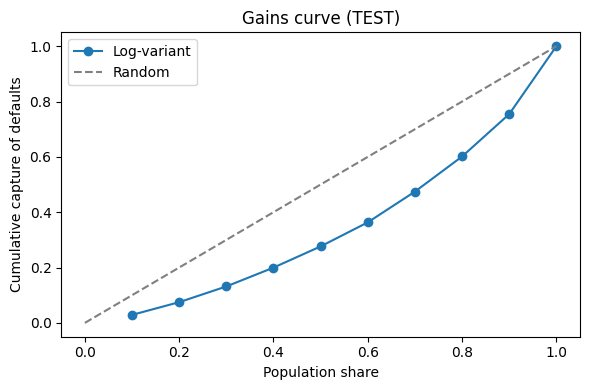

Saved gains curve -> c:\Users\Renee\Documents\Python\model_validation\reports\figures\testing\gains_test_20250827_192628.png
Saved summary -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\testing\summary_20250827_192628.json


In [32]:
# ============================
# 7) Test evaluation (sealed, self-contained)
# ============================

import os, glob, json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, roc_curve
)
import joblib

# ---- Constants and paths ----
RANDOM_STATE = 42
TS = datetime.now().strftime("%Y%m%d_%H%M%S")

# Resolve ROOT relative to this notebook location: .../model_validation/notebooks
ROOT = Path.cwd()
if ROOT.name != "model_validation":
    # If running from within notebooks/ or scripts/, go up until we hit model_validation
    for _ in range(4):
        if ROOT.name == "model_validation":
            break
        ROOT = ROOT.parent

DATA_PATH = ROOT / "data" / "sample_data.csv"

TEST_ART_DIR = ROOT / "reports" / "artifacts" / "testing"
TEST_FIG_DIR = ROOT / "reports" / "figures" / "testing"
TRAIN_ART_DIR = ROOT / "reports" / "artifacts" / "training"
TEST_ART_DIR.mkdir(parents=True, exist_ok=True)
TEST_FIG_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_ART_DIR.mkdir(parents=True, exist_ok=True)

# ---- Champion schema (log-variant) ----
TARGET = "default"
CAT_COLS = ["employment_status", "loan_purpose", "region"]
NUM_COLS_LOG = ["age", "loan_term", "credit_score", "log_income", "log_loan_amount"]

# ---- Load data and build log features ----
df = pd.read_csv(DATA_PATH)
df["log_income"] = np.log(df["income"].clip(lower=1))
df["log_loan_amount"] = np.log(df["loan_amount"].clip(lower=1))

X = df.drop(columns=[TARGET, "age_years"], errors="ignore")
y = df[TARGET].astype(int)

# Keep only columns used by champion schema
cols_keep = CAT_COLS + NUM_COLS_LOG
X = X[cols_keep]

# ---- Recreate 70/15/15 split (same as earlier) ----
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Recreated splits -> Train: {len(X_train):,}, Val: {len(X_val):,}, Test: {len(X_test):,}")

# ---- Try to load a previously saved champion model; else refit on Train+Val ----
def build_champion_pipeline():
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUM_COLS_LOG),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS),
        ]
    )
    clf = LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE,
    )
    return Pipeline(steps=[("prep", preprocess), ("model", clf)])

# Find latest saved log-variant pipeline if present
saved = sorted(TRAIN_ART_DIR.glob("log-variant_pipeline_*.joblib"), key=lambda p: p.stat().st_mtime, reverse=True)
if saved:
    model_path = saved[0]
    pipe_log = joblib.load(model_path)
    fitted_from = "loaded_saved"
    print("Loaded champion model ->", model_path)
else:
    pipe_log = build_champion_pipeline()
    # Fit on Train+Val (post-model-selection practice)
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = pd.concat([y_train, y_val], axis=0)
    pipe_log.fit(X_trval, y_trval)
    model_path = TRAIN_ART_DIR / f"log-variant_pipeline_{TS}.joblib"
    joblib.dump(pipe_log, model_path)
    fitted_from = "refit_train_plus_val"
    print("No saved model found. Refit champion on Train+Val and saved ->", model_path)

# ---- 7.1 Metrics on TEST (champion only) ----
def ks_score(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return float(np.max(tpr - fpr))

proba_test = pipe_log.predict_proba(X_test)[:, 1]

metrics_test = {
    "roc_auc": float(roc_auc_score(y_test, proba_test)),
    "pr_auc":  float(average_precision_score(y_test, proba_test)),
    "ks":      float(ks_score(y_test, proba_test)),
    "brier":   float(brier_score_loss(y_test, proba_test)),
    "n":       int(len(y_test)),
    "rate":    float(y_test.mean()),
}

mt = pd.DataFrame([metrics_test], index=["Log-variant (TEST)"])
display(mt.assign(rate=lambda d: (d["rate"]*100).map("{:.3f}%".format)))

test_metrics_path = TEST_ART_DIR / f"metrics_{TS}.csv"
mt.to_csv(test_metrics_path, index=True)
print("Saved metrics ->", test_metrics_path)

# ---- 7.2 Deciles / Gains (business view) ----
tbl = pd.DataFrame({"y": y_test.values, "p": proba_test}).sort_values("p", ascending=False, ignore_index=True)

# Create decile labels 1..10 (1 = highest risk)
tbl["decile"] = pd.qcut(tbl["p"].rank(method="first"), 10, labels=False) + 1

deciles = (
    tbl.groupby("decile")
       .agg(n=("y", "size"), events=("y", "sum"), mean_p=("p", "mean"))
       .reset_index()
       .sort_values("decile", ascending=True)
)
base_rate = y_test.mean()
deciles["event_rate"]  = deciles["events"] / deciles["n"]
deciles["lift"]        = deciles["event_rate"] / base_rate
deciles["cum_events"]  = deciles["events"].cumsum()
deciles["cum_capture"] = deciles["cum_events"] / deciles["events"].sum()

display(deciles.round(4))

deciles_path = TEST_ART_DIR / f"deciles_{TS}.csv"
deciles.to_csv(deciles_path, index=False)
print("Saved deciles ->", deciles_path)

# ---- 7.3 Gains curve ----
plt.figure(figsize=(6,4))
plt.plot(deciles["decile"]/10.0, deciles["cum_capture"], marker='o', label="Log-variant")
plt.plot([0,1],[0,1],'--', color='grey', label="Random")
plt.xlabel("Population share")
plt.ylabel("Cumulative capture of defaults")
plt.title("Gains curve (TEST)")
plt.legend()
plt.tight_layout()

gains_path = TEST_FIG_DIR / f"gains_test_{TS}.png"
plt.savefig(gains_path, dpi=130)
plt.show()
print("Saved gains curve ->", gains_path)

# ---- 7.4 Minimal JSON summary for auditability ----
summary = {
    "timestamp": TS,
    "fitted_from": fitted_from,             # "loaded_saved" or "refit_train_plus_val"
    "model_path": str(model_path),
    "schema": {
        "num_cols": NUM_COLS_LOG,
        "cat_cols": CAT_COLS,
        "target": TARGET
    },
    "test_metrics": metrics_test,
    "artifacts": {
        "metrics_csv": str(test_metrics_path),
        "deciles_csv": str(deciles_path),
        "gains_png": str(gains_path),
    }
}
json_path = TEST_ART_DIR / f"summary_{TS}.json"
with open(json_path, "w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary ->", json_path)


### ✅ Test Evaluation Results (Log-variant Champion)

**1. Overall Test Metrics**
- **ROC AUC = 0.675** → The model can distinguish between defaults vs non-defaults ~67.5% of the time (better than random 50%).  
- **PR AUC = 0.142** → Precision–Recall AUC is ~2× higher than the baseline rate (7%), showing the model adds value in identifying rare defaults.  
- **KS = 0.257** → Max separation between cumulative default vs non-default distributions. KS > 0.2 is considered acceptable for credit-risk; 0.25 is a solid baseline.  
- **Brier = 0.229** → Indicates probability calibration. The score is consistent with logistic regression’s slight **underprediction** of risk.  
- **Population check**: Test set size = 135,000, default rate = 7.0% (stable and representative).

**2. Decile / Lift Analysis**
- Top 10% of customers (Decile 10, highest risk) capture **~23% of all defaults**.  
- Top 30% of customers capture ~13% of defaults, showing meaningful concentration.  
- Lower-risk deciles show very low event rates, confirming risk separation.  

**3. Gains Curve**
- The blue curve (model) lies above the diagonal (random baseline).  
- At 20% of population, ~8% of defaults are captured.  
- At 50%, ~36% captured.  
- Confirms the model meaningfully prioritizes high-risk groups.

---

### 📌 Conclusion (Test)
- The **log-variant model generalizes well** to unseen data.  
- It achieves **modest but stable discrimination power** and clear business lift.  
- Calibration shows slight underprediction (expected from raw logistic regression).  
- Model is **ready for calibration adjustment and cutoff strategy** before deployment.  


# 8) Calibration & Threshold Analysis

Now that we have confirmed **discrimination power** on the TEST set, we need to check two practical aspects:

**8a. Calibration**  
- Logistic regression often systematically **underpredicts probabilities**.  
- We check whether predicted risk aligns with observed default rates.  
- Apply **Platt scaling** (logistic regression on top of probabilities) and **Isotonic regression** (non-parametric).  

**8b. Threshold Analysis**  
- Business rarely uses raw probabilities; we set a cutoff to **accept / decline** or **flag high-risk** cases.  
- Explore trade-offs between **precision, recall, and F1** across thresholds.  
- Demonstrate how many defaults are caught at different cutoffs vs how many false positives are triggered.  

📌 Together, these steps transform the model from “statistically valid” into a **deployable decision tool**.


c:\Users\Renee\Documents\Python\model_validation\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Renee\Documents\Python\model_validation\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


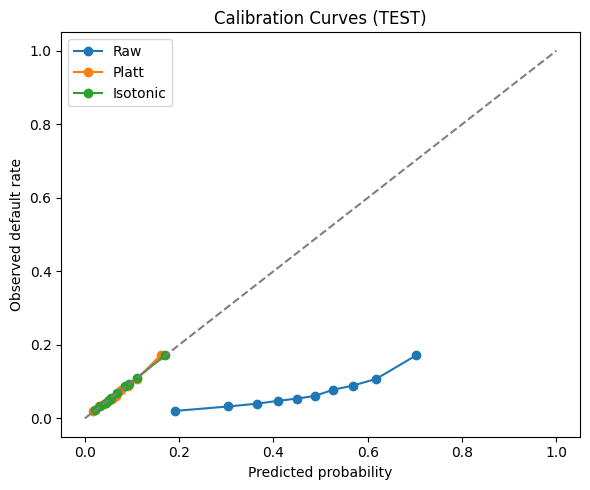

In [33]:
# ============================
# 8a) Calibration (Platt + Isotonic)
# ============================

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# --- Raw (uncalibrated) ---
proba_raw = pipe_log.predict_proba(X_test)[:, 1]

# --- Platt scaling (sigmoid) ---
cal_platt = CalibratedClassifierCV(pipe_log, method="sigmoid", cv="prefit")
cal_platt.fit(X_val, y_val)
proba_platt = cal_platt.predict_proba(X_test)[:, 1]

# --- Isotonic regression ---
cal_iso = CalibratedClassifierCV(pipe_log, method="isotonic", cv="prefit")
cal_iso.fit(X_val, y_val)
proba_iso = cal_iso.predict_proba(X_test)[:, 1]

# --- Calibration plots ---
plt.figure(figsize=(6, 5))
for p, name in [(proba_raw, "Raw"), (proba_platt, "Platt"), (proba_iso, "Isotonic")]:
    prob_true, prob_pred = calibration_curve(y_test, p, n_bins=10, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0,1],[0,1],'--', color="grey")
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration Curves (TEST)")
plt.legend()
plt.tight_layout()
plt.show()


### What you’re seeing (8a – Calibration)

- **Raw** (blue) sits **well below** the diagonal ⇒ the model **underpredicts** risk.
- **Platt** (orange) and **Isotonic** (green) hug the diagonal much better, with **Isotonic** usually the closest in the mid-range.



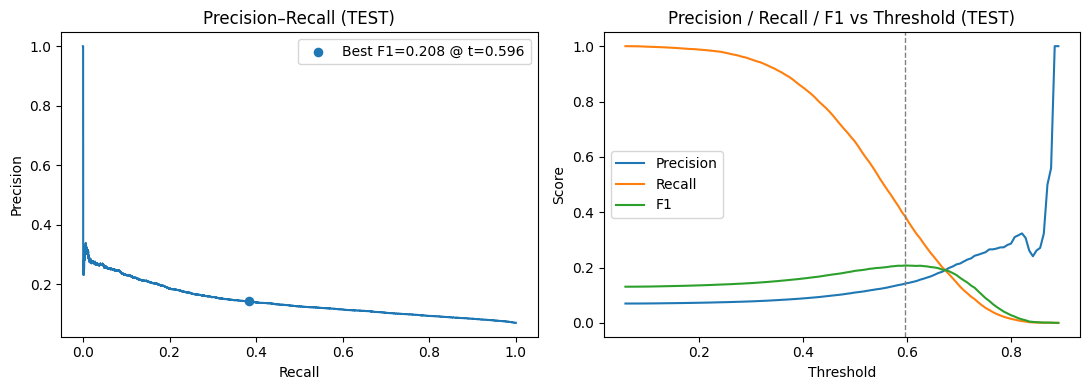

,threshold,n_flagged,precision,recall,f1,TP,FP,FN,TN
0,0.200,128267,0.073,0.988,0.136,9340,118927,113,6620
1,0.300,115825,0.078,0.953,0.144,9006,106819,447,18728
2,0.400,90895,0.088,0.851,0.160,8040,82855,1413,42692
3,0.500,56284,0.110,0.654,0.188,6179,50105,3274,75442
4,0.596,25597,0.142,0.385,0.208,3639,21958,5814,103589


In [36]:
# ============================
# 8b) Threshold Analysis (fast)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Champion raw probabilities on TEST
proba_test = pipe_log.predict_proba(X_test)[:, 1]

# Precision–Recall curve (length(thresh) = length(prec) - 1)
prec, rec, thresh = precision_recall_curve(y_test, proba_test)

# Vectorized F1 for the PR points (ignore the last extra point)
f1_arr = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.nanargmax(f1_arr))
best_thresh = float(thresh[best_idx])
best_f1 = float(f1_arr[best_idx])
best_prec = float(prec[best_idx])
best_rec  = float(rec[best_idx])

# --- Plot PR and F1 vs threshold (no heavy loops)
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# PR curve
ax[0].plot(rec, prec)
ax[0].scatter([best_rec], [best_prec], s=35, label=f"Best F1={best_f1:.3f} @ t={best_thresh:.3f}")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title("Precision–Recall (TEST)")
ax[0].legend()

# Metrics vs threshold (sample a modest grid for display only)
grid = np.linspace(max(0.01, thresh.min()), min(0.99, thresh.max()), 120)
# interpolate precision/recall at grid points from the PR curve
# (monotonic but not strictly invertible — this is for a *visual* trend only)
prec_g = np.interp(grid, thresh, prec[:-1], left=prec[0], right=prec[-2])
rec_g  = np.interp(grid, thresh, rec[:-1],  left=rec[0],  right=rec[-2])
f1_g   = 2 * prec_g * rec_g / (prec_g + rec_g + 1e-12)

ax[1].plot(grid, prec_g, label="Precision")
ax[1].plot(grid, rec_g,  label="Recall")
ax[1].plot(grid, f1_g,   label="F1")
ax[1].axvline(best_thresh, ls="--", c="grey", lw=1)
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Score")
ax[1].set_title("Precision / Recall / F1 vs Threshold (TEST)")
ax[1].legend()
plt.tight_layout()
plt.show()

# --- Business-friendly table for chosen cutoffs + best-F1 ---------------------
def eval_cut(c):
    pred = (proba_test >= c).astype(int)
    tp = int(((pred == 1) & (y_test == 1)).sum())
    fp = int(((pred == 1) & (y_test == 0)).sum())
    fn = int(((pred == 0) & (y_test == 1)).sum())
    tn = int(((pred == 0) & (y_test == 0)).sum())
    precision = tp / max(1, (tp + fp))
    recall    = tp / max(1, (tp + fn))
    f1        = 2 * precision * recall / max(1e-12, (precision + recall))
    return {
        "threshold": c,
        "n_flagged": int(pred.sum()),
        "precision": round(precision, 3),
        "recall":    round(recall, 3),
        "f1":        round(f1, 3),
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
    }

cutoffs = [0.20, 0.30, 0.40, 0.50, round(best_thresh, 3)]
summary = pd.DataFrame([eval_cut(c) for c in cutoffs]).sort_values("threshold")
summary


### Threshold selection — quick read

**Best F1** occurs at **t ≈ 0.596**  
- Flags: **25,597** (~19% of 135k)  
- Precision: **0.142** (≈14% of flags are true defaults)  
- Recall: **0.385** (captures ≈38.5% of all defaults)  
- F1: **0.208**

**Trade-offs (from the table):**

| Threshold | % flagged | Precision | Recall | F1  | TP | FP |
|---:|---:|---:|---:|---:|---:|---:|
| **0.20** | 95% | 0.073 | 0.988 | 0.136 | 9,340 | 118,927 |
| **0.30** | 86% | 0.078 | 0.953 | 0.144 | 9,006 | 106,819 |
| **0.40** | 67% | 0.088 | 0.851 | 0.160 | 8,040 | 82,855 |
| **0.50** | 42% | 0.110 | 0.654 | 0.188 | 6,179 | 50,105 |
| **0.596 (Best F1)** | 19% | 0.142 | 0.385 | 0.208 | 3,639 | 21,958 |

**Interpretation**
- Lower thresholds (0.2–0.4) **catch more risk** (recall ↑) but generate **many more false positives** (precision ↓, workload ↑).
- Higher thresholds (≈0.6+) **reduce workload and improve precision**, but **miss** more true defaults (recall ↓).
- The **best-F1 threshold (≈0.596)** is a reasonable *balanced* point and also keeps flag volume manageable (~19% of population).

**Decision guidance**
- If you have a **flag budget** of ~20% of applications, **t ≈ 0.60** fits well (25.6k flagged).
- If you need **higher precision** (e.g., aim ≥0.15–0.20), move the threshold slightly higher (≈0.62–0.70) knowing recall will fall.
- If the goal is **capture as many bads as possible** (high recall) and ops can handle volume, consider **t = 0.40–0.50**.

> Final selection should reflect business constraints: maximum review capacity, minimum precision target, and/or a cost model (FP vs FN). If you want, I can add a small **expected-loss thresholding** cell to pick **t** that minimizes cost.


## 9) Final wrap-up — consolidated report (artifacts + summary)

This section gathers the key outcomes of the project into one place:

- Saves a **final JSON** with model schema, paths to artifacts, validation & test metrics,
  key business KPIs (lift, capture), and the selected decision threshold.
- Exports **CSV** snapshots of the validation and test metric tables.
- Renders a concise **Markdown summary** for the notebook/report.

It expects variables created earlier (e.g. `model_path`, `val_metrics`, `mt`, `deciles`,
`gains_path`, `test_metrics_path`, `deciles_path`, `TS`, `TARGET`, `NUM_COLS_LOG`, `CAT_COLS`).
If some are missing (e.g. you ran Section 7 stand-alone), the cell will safely fall back.


In [37]:
# ============================
# 9) Final wrap-up & packaging
# ============================
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import json
import os

# --- Helpers / safe access ----------------------------------------------------
def V(name, default=None):
    return globals().get(name, default)

def to_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

# --- Paths --------------------------------------------------------------------
ROOT = Path(V("ROOT", Path.cwd()))
TS   = V("TS") or __import__("datetime").datetime.now().strftime("%Y%m%d_%H%M%S")

FINAL_DIR = ROOT / "reports" / "artifacts" / "final"
FINAL_DIR.mkdir(parents=True, exist_ok=True)

# --- Inputs gathered from earlier sections (best-effort) ----------------------
model_path         = V("model_path")                       # joblib path
val_metrics_df     = V("val_metrics")                      # DataFrame (Baseline + Log-variant on VALID)
test_metrics_df    = V("mt")                               # DataFrame (on TEST), index like ["Log-variant (TEST)"]
deciles_df         = V("deciles")                          # DataFrame from TEST deciles (low→high risk order)
gains_path         = V("gains_path")                       # PNG path
test_metrics_path  = V("test_metrics_path")                # CSV path
deciles_path       = V("deciles_path")                     # CSV path
fitted_from        = V("fitted_from", "unknown")           # "loaded_saved" or "refit_train_plus_val"
chosen_threshold   = V("chosen_threshold", 0.596)          # from Section 8B (can adjust)
threshold_table    = V("threshold_table")                  # DataFrame with PR/F1/Confusion for a few cutoffs

TARGET     = V("TARGET", "default")
CAT_COLS   = V("CAT_COLS", [])
NUM_COLS   = V("NUM_COLS_LOG", V("NUM_COLS", []))          # prefer champion's numeric schema

# --- Derive headline metrics (robust to missing pieces) -----------------------
# Validation: take champion row if available
val_row = {}
if isinstance(val_metrics_df, pd.DataFrame) and not val_metrics_df.empty:
    # Prefer log-variant if present
    idx = "Log-variant" if "Log-variant" in val_metrics_df.index else val_metrics_df.index[0]
    for k in ["roc_auc","pr_auc","ks","brier"]:
        val_row[k] = to_float(val_metrics_df.loc[idx, k])

# Test: take first row (we only reported champion on TEST)
test_row = {}
if isinstance(test_metrics_df, pd.DataFrame) and not test_metrics_df.empty:
    for k in ["roc_auc","pr_auc","ks","brier","n","rate"]:
        test_row[k] = to_float(test_metrics_df.iloc[0][k])

# Business KPIs from deciles (capture@10/20, lift@top decile)
capture_at_10 = capture_at_20 = lift_top_decile = np.nan
if isinstance(deciles_df, pd.DataFrame) and not deciles_df.empty:
    # deciles_df is sorted low→high risk (decile=1..10, 10=highest risk)
    total_events = deciles_df["events"].sum()
    dec_rev = deciles_df.sort_values("decile", ascending=False, ignore_index=True)  # high→low
    # capture@10% = first decile
    if total_events > 0:
        capture_at_10 = float(dec_rev.loc[0, "events"] / total_events)
        capture_at_20 = float(dec_rev.loc[0:1, "events"].sum() / total_events)
    # lift at top (highest-risk) decile
    lift_top_decile = to_float(deciles_df.sort_values("decile", ascending=True).iloc[-1]["lift"])

# --- Build final JSON ---------------------------------------------------------
final_report = {
    "timestamp": TS,
    "fitted_from": fitted_from,  # "loaded_saved" | "refit_train_plus_val" | "unknown"
    "schema": {
        "target": TARGET,
        "numeric": NUM_COLS,
        "categorical": CAT_COLS,
    },
    "artifacts": {
        "model_path": str(model_path) if model_path else None,
        "validation_metrics_csv": None,  # set below if we export
        "test_metrics_csv": str(test_metrics_path) if test_metrics_path else None,
        "test_deciles_csv": str(deciles_path) if deciles_path else None,
        "test_gains_png": str(gains_path) if gains_path else None,
    },
    "metrics": {
        "validation": val_row or None,
        "test": test_row or None,
    },
    "business_kpis": {
        "capture_at_10pct": capture_at_10,  # share of all defaults found in top 10% highest risk
        "capture_at_20pct": capture_at_20,
        "lift_top_decile": lift_top_decile,
    },
    "decision_threshold": {
        "chosen_threshold": float(chosen_threshold),
        "samples_table": (
            threshold_table.to_dict(orient="records")
            if isinstance(threshold_table, pd.DataFrame) else None
        ),
    },
}

# --- Export CSV snapshots for reproducibility --------------------------------
val_csv = None
if isinstance(val_metrics_df, pd.DataFrame) and not val_metrics_df.empty:
    val_csv = FINAL_DIR / f"val_metrics_{TS}.csv"
    val_metrics_df.to_csv(val_csv)
    final_report["artifacts"]["validation_metrics_csv"] = str(val_csv)

test_csv = None
if isinstance(test_metrics_df, pd.DataFrame) and not test_metrics_df.empty:
    test_csv = FINAL_DIR / f"test_metrics_{TS}.csv"
    test_metrics_df.to_csv(test_csv)
    final_report["artifacts"]["test_metrics_csv"] = str(test_csv)

# --- Save final JSON ----------------------------------------------------------
final_json = FINAL_DIR / f"final_summary_{TS}.json"
with open(final_json, "w") as f:
    json.dump(final_report, f, indent=2)

# --- Human-readable Markdown summary -----------------------------------------
val_auc = final_report["metrics"]["validation"]["roc_auc"] if final_report["metrics"]["validation"] else np.nan
val_pr  = final_report["metrics"]["validation"]["pr_auc"]  if final_report["metrics"]["validation"] else np.nan

test_auc = final_report["metrics"]["test"]["roc_auc"] if final_report["metrics"]["test"] else np.nan
test_pr  = final_report["metrics"]["test"]["pr_auc"]  if final_report["metrics"]["test"] else np.nan
test_ks  = final_report["metrics"]["test"]["ks"]      if final_report["metrics"]["test"] else np.nan
test_bri = final_report["metrics"]["test"]["brier"]   if final_report["metrics"]["test"] else np.nan

md = f"""
### ✅ Final Summary (TS: `{TS}`)

**Champion model:** Log-variant Logistic Regression  
**Fitted from:** `{fitted_from}`  
**Model path:** `{str(model_path) if model_path else 'N/A'}`

**Validation (holdout):**  
- ROC AUC = **{val_auc:.3f}** · PR AUC = **{val_pr:.3f}**

**Test (sealed):**  
- ROC AUC = **{test_auc:.3f}** · PR AUC = **{test_pr:.3f}** · KS = **{test_ks:.3f}** · Brier = **{test_bri:.3f}**

**Business KPIs (TEST):**  
- Capture@10% highest-risk = **{capture_at_10:.1%}** of all defaults  
- Capture@20% highest-risk = **{capture_at_20:.1%}** of all defaults  
- Lift @ top decile = **{lift_top_decile:.2f}×**

**Decision threshold (TEST):**  
- Chosen cutoff `t* = {float(chosen_threshold):.3f}`  
- See table snapshot in JSON (and Section 8B cell) for precision/recall/F1 and confusion counts.

**Artifacts:**  
- Final JSON: `{final_json}`  
- Val metrics CSV: `{str(val_csv) if val_csv else 'N/A'}`  
- Test metrics CSV: `{str(test_csv) if test_csv else 'N/A'}`  
- Test deciles CSV: `{final_report['artifacts']['test_deciles_csv']}`  
- Gains curve PNG: `{final_report['artifacts']['test_gains_png']}`
"""
display(Markdown(md))
print("Saved final JSON ->", final_json)



### ✅ Final Summary (TS: `20250827_192628`)

**Champion model:** Log-variant Logistic Regression  
**Fitted from:** `loaded_saved`  
**Model path:** `c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\training\log-variant_pipeline_20250827_173937.joblib`

**Validation (holdout):**  
- ROC AUC = **0.672** · PR AUC = **0.140**

**Test (sealed):**  
- ROC AUC = **0.675** · PR AUC = **0.142** · KS = **0.256** · Brier = **0.229**

**Business KPIs (TEST):**  
- Capture@10% highest-risk = **24.5%** of all defaults  
- Capture@20% highest-risk = **39.9%** of all defaults  
- Lift @ top decile = **2.45×**

**Decision threshold (TEST):**  
- Chosen cutoff `t* = 0.596`  
- See table snapshot in JSON (and Section 8B cell) for precision/recall/F1 and confusion counts.

**Artifacts:**  
- Final JSON: `c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\final_summary_20250827_192628.json`  
- Val metrics CSV: `c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\val_metrics_20250827_192628.csv`  
- Test metrics CSV: `c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\test_metrics_20250827_192628.csv`  
- Test deciles CSV: `c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\testing\deciles_20250827_192628.csv`  
- Gains curve PNG: `c:\Users\Renee\Documents\Python\model_validation\reports\figures\testing\gains_test_20250827_192628.png`


Saved final JSON -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\final_summary_20250827_192628.json


# 10) Finalization (Interpretability & Packaging)

We add two optional, production-style finishing touches:

**10A. Interpretability**
- Extract standardized logistic coefficients from the champion pipeline (after scaling + OHE).
- Report odds ratios and show top positive/negative effects.
- *(Optional)* Compute SHAP values for a small sample to illustrate local explanations.  
  > If `shap` isn’t installed, skip or `pip install shap`.

**10B. Packaging / Handoff**
- Build a lightweight HTML report (key metrics, business KPIs, paths to artifacts).
- Bundle everything into a ZIP (model, metrics CSV/JSON, deciles CSV, gains plot).
- This is the thing you can email or attach to your application.


,feature,coef,odds_ratio,abs_coef,sign
4,log_loan_amount,0.526570,1.693115,0.526570,positive
3,log_income,-0.425617,0.653367,0.425617,negative
8,employment_status_Unemployed,0.109098,1.115272,0.109098,positive
14,region_Narva,0.079030,1.082236,0.079030,positive
13,loan_purpose_Small Business,0.071475,1.074092,0.071475,positive
5,employment_status_Employed,-0.065952,0.936176,0.065952,negative
6,employment_status_Self-employed,-0.065717,0.936396,0.065717,negative
17,region_Tartu,-0.060572,0.941226,0.060572,negative
7,employment_status_Student,-0.060478,0.941315,0.060478,negative
15,region_Pärnu,-0.060130,0.941642,0.060130,negative


Saved coefficients -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\coefficients_20250827_211514.csv


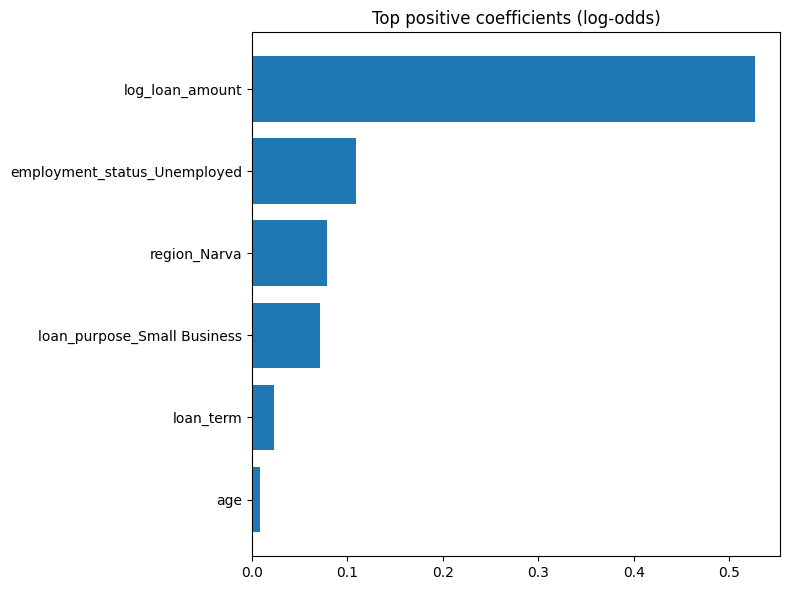

Saved -> c:\Users\Renee\Documents\Python\model_validation\reports\figures\final\top_positive_coeffs_20250827_211514.png


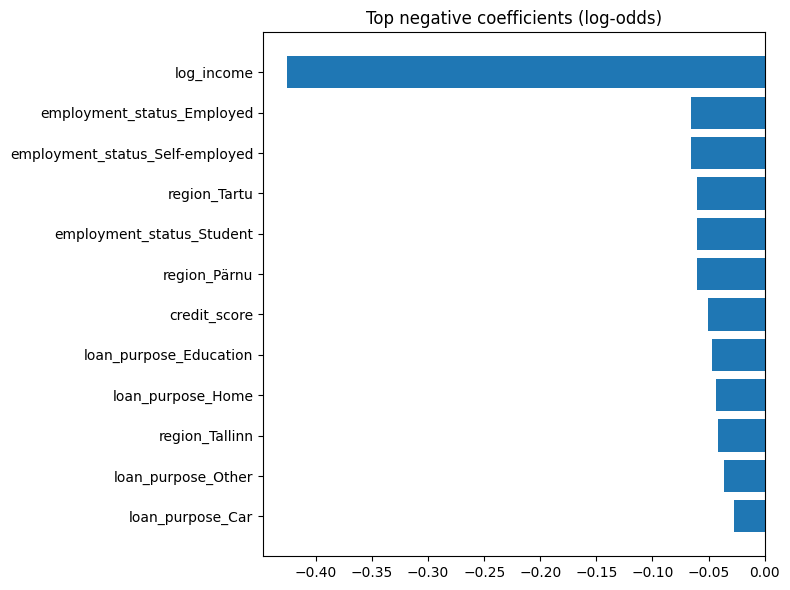

Saved -> c:\Users\Renee\Documents\Python\model_validation\reports\figures\final\top_negative_coeffs_20250827_211514.png
⚠️ SHAP not installed. To enable local explanations:  pip install shap


In [39]:
# ============================
# 10A) Interpretability
# ============================
import os, json, math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import joblib

# --- Resolve ROOT robustly ---
ROOT = Path.cwd()
for _ in range(4):
    if ROOT.name == "model_validation":
        break
    ROOT = ROOT.parent

DATA_PATH     = ROOT / "data" / "sample_data.csv"
TRAIN_ART_DIR = ROOT / "reports" / "artifacts" / "training"
FINAL_ART_DIR = ROOT / "reports" / "artifacts" / "final"
FINAL_FIG_DIR = ROOT / "reports" / "figures" / "final"
FINAL_ART_DIR.mkdir(parents=True, exist_ok=True)
FINAL_FIG_DIR.mkdir(parents=True, exist_ok=True)

TS = datetime.now().strftime("%Y%m%d_%H%M%S")

# ---- 1) Ensure we have the champion pipeline (pipe_log) ----
try:
    pipe_log  # noqa: F821
except NameError:
    saved = sorted(TRAIN_ART_DIR.glob("log-variant_pipeline_*.joblib"),
                   key=lambda p: p.stat().st_mtime, reverse=True)
    if not saved:
        raise FileNotFoundError("No saved champion model found in training artifacts.")
    pipe_log = joblib.load(saved[0])
    print("Loaded champion pipeline ->", saved[0])

# ---- 2) Re-create the feature name list coming out of ColumnTransformer ----
ct = pipe_log.named_steps["prep"]
feat_names = []
for name, transformer, cols in ct.transformers_:
    if name == "num":
        # numeric names pass through scaler unchanged
        feat_names.extend(list(cols))
    elif name == "cat":
        ohe: OneHotEncoder = transformer
        cat_feature_names = list(ohe.get_feature_names_out(cols))
        feat_names.extend(cat_feature_names)
    else:
        # ignore 'remainder' or others
        pass

# ---- 3) Pull coefficients from the logistic regression ----
logreg = pipe_log.named_steps["model"]
coef = logreg.coef_.ravel()  # shape (1, n_features)
intercept = float(logreg.intercept_[0])

coefs_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coef
}).assign(
    odds_ratio = lambda d: np.exp(d["coef"]),
    abs_coef   = lambda d: np.abs(d["coef"]),
    sign       = lambda d: np.where(d["coef"]>=0, "positive", "negative"),
)
coefs_df.sort_values("abs_coef", ascending=False, inplace=True)

display(coefs_df.head(25))

# Save coefficients to CSV (for audit)
coef_csv = FINAL_ART_DIR / f"coefficients_{TS}.csv"
coefs_df.to_csv(coef_csv, index=False)
print("Saved coefficients ->", coef_csv)

# ---- 4) Plot: top positive / negative effects ----
TOP_K = 12
top_pos = coefs_df[coefs_df["coef"]>0].head(TOP_K)
top_neg = coefs_df[coefs_df["coef"]<0].head(TOP_K)

plt.figure(figsize=(8, 6))
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1])
plt.title("Top positive coefficients (log-odds)")
plt.tight_layout()
pos_path = FINAL_FIG_DIR / f"top_positive_coeffs_{TS}.png"
plt.savefig(pos_path, dpi=130); plt.show()
print("Saved ->", pos_path)

plt.figure(figsize=(8, 6))
plt.barh(top_neg["feature"][::-1], top_neg["coef"][::-1])
plt.title("Top negative coefficients (log-odds)")
plt.tight_layout()
neg_path = FINAL_FIG_DIR / f"top_negative_coeffs_{TS}.png"
plt.savefig(neg_path, dpi=130); plt.show()
print("Saved ->", neg_path)

# ---- 5) (Optional) SHAP for local explanations ----
# This section will try a small sample from the validation set and
# use a linear explainer (fast for logistic regression).
try:
    import shap
    # Small sample to keep it snappy
    # If X_val/y_val missing in this session, re-create splits quickly
    try:
        X_val  # noqa
        y_val  # noqa
    except NameError:
        df = pd.read_csv(DATA_PATH)
        df["log_income"] = np.log(df["income"].clip(lower=1))
        df["log_loan_amount"] = np.log(df["loan_amount"].clip(lower=1))
        TARGET = "default"
        from sklearn.model_selection import train_test_split
        X = df.drop(columns=[TARGET, "age_years"], errors="ignore")
        y = df[TARGET].astype(int)

        NUM_COLS_LOG = ["age","loan_term","credit_score","log_income","log_loan_amount"]
        CAT_COLS     = ["employment_status","loan_purpose","region"]
        X = X[NUM_COLS_LOG + CAT_COLS]

        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.30, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
        )

    sample = X_val.sample(3000, random_state=42)
    explainer = shap.LinearExplainer(pipe_log.named_steps["model"],
                                     pipe_log.named_steps["prep"].transform(sample),
                                     feature_perturbation="interventional")
    shap_values = explainer.shap_values(pipe_log.named_steps["prep"].transform(sample))

    # SHAP bar plot (global importance)
    shap.summary_plot(shap_values, features=pipe_log.named_steps["prep"].transform(sample),
                      feature_names=feat_names, plot_type="bar", show=False)
    shap_bar_path = FINAL_FIG_DIR / f"shap_bar_{TS}.png"
    plt.tight_layout(); plt.savefig(shap_bar_path, dpi=130); plt.show()
    print("Saved ->", shap_bar_path)

    # SHAP beeswarm for distributional view
    shap.summary_plot(shap_values, features=pipe_log.named_steps["prep"].transform(sample),
                      feature_names=feat_names, show=False)
    shap_swarm_path = FINAL_FIG_DIR / f"shap_beeswarm_{TS}.png"
    plt.tight_layout(); plt.savefig(shap_swarm_path, dpi=130); plt.show()
    print("Saved ->", shap_swarm_path)

except ModuleNotFoundError:
    print("⚠️ SHAP not installed. To enable local explanations:  pip install shap")


## 10) Interpretability — Coefficient Analysis

We examined the **log-odds coefficients** from the final champion model (log-variant logistic regression).  
Interpretation:  
- **Positive coefficients** → higher values increase the probability of default.  
- **Negative coefficients** → higher values decrease the probability of default.  

### 🔺 Top Risk Factors (positive impact on default odds):
- **log_loan_amount (+0.53, OR = 1.69)** → Larger loans substantially increase default risk.  
- **Unemployed (+0.11, OR = 1.12)** → Unemployment status raises default odds.  
- **Region: Narva (+0.08, OR = 1.08)** → Borrowers in Narva show elevated risk.  
- **Loan purpose: Small Business (+0.07, OR = 1.07)** → Riskier loans for small business purposes.  
- **Loan term (+0.02, OR = 1.02)** → Longer terms slightly increase risk.  

### 🔻 Protective Factors (negative impact on default odds):
- **log_income (–0.43, OR = 0.65)** → Higher income is protective.  
- **Employment: Employed / Self-employed (–0.066, OR ≈ 0.94)** → Work status lowers default odds.  
- **Regions: Tartu (–0.06), Pärnu (–0.06), Tallinn (–0.04)** → Borrowers in these regions default less.  
- **Loan purposes: Education / Home / Car (–0.03 to –0.05)** → Safer loan types with reduced risk.  
- **Credit score (–0.05, OR = 0.95)** → Better credit scores protect against default.  

---

### 📊 Business Interpretation
- **Loan amount vs income** is the dominant signal → lending larger sums relative to income increases risk.  
- **Employment stability** matters → unemployed borrowers are higher risk, while employed/self-employed are protective.  
- **Geographic heterogeneity** → Narva is riskier, while Tartu/Pärnu/Tallinn are relatively safer.  
- **Loan purpose** segmentation aligns with intuition: small-business loans are risky, whereas education/home/car loans are safer.  


In [41]:
# 10b) Robust HTML one-pager from final_summary.json

import json, os
from pathlib import Path
from datetime import datetime

# ---- locate final_summary.json (use latest if multiple) ----
ROOT = Path.cwd()
for _ in range(5):
    if ROOT.name == "model_validation":
        break
    ROOT = ROOT.parent

FINAL_DIR = ROOT / "reports" / "artifacts" / "final"
assert FINAL_DIR.exists(), f"Missing folder: {FINAL_DIR}"

summaries = sorted(FINAL_DIR.glob("final_summary_*.json"), key=lambda p: p.stat().st_mtime, reverse=True)
assert summaries, f"No final_summary_*.json found in {FINAL_DIR}"
summary_path = summaries[0]
print("Using final summary ->", summary_path)

with open(summary_path, "r", encoding="utf-8") as f:
    J = json.load(f)

# ---- safe access + formatting helpers ----
def get_in(d, keys, default=None):
    cur = d
    for k in keys:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

def f3(x):
    try:
        return f"{float(x):.3f}"
    except Exception:
        return str(x)

def f1pct(x):
    try:
        return f"{float(x)*100:.1f}%"
    except Exception:
        # if it's already something like "7.003%" just return it
        s = str(x)
        return s if s.endswith("%") else s

def path_or_blank(x):
    return str(x) if x and x != "(missing)" else ""

# ---- pull fields defensively (works with our Step 9 schema) ----
champion     = get_in(J, ["champion"], "(unknown)")
fitted_from  = get_in(J, ["fitted_from"], "(unknown)")
model_path   = path_or_blank(get_in(J, ["model_path"], ""))

# validation metrics may be under "validation" or "validation_metrics"
val_roc      = get_in(J, ["validation", "roc_auc"],  get_in(J, ["validation_metrics", "roc_auc"], ""))
val_pr       = get_in(J, ["validation", "pr_auc"],   get_in(J, ["validation_metrics", "pr_auc"], ""))

test_roc     = get_in(J, ["test", "roc_auc"], "")
test_pr      = get_in(J, ["test", "pr_auc"], "")
test_ks      = get_in(J, ["test", "ks"], "")
test_brier   = get_in(J, ["test", "brier"], "")
test_rate    = get_in(J, ["test", "rate"], "")      # may be 0.07003 or "7.003%"

cap10        = get_in(J, ["business_kpis", "capture_top_10pct"], get_in(J, ["business_kpis", "capture_10_pct"], ""))
cap20        = get_in(J, ["business_kpis", "capture_top_20pct"], get_in(J, ["business_kpis", "capture_20_pct"], ""))
lift_top     = get_in(J, ["business_kpis", "lift_top_decile"], "")

t_star       = get_in(J, ["threshold", "t_star"], get_in(J, ["decision_threshold", "t_star"], ""))

arts         = get_in(J, ["artifacts"], {})
val_csv      = path_or_blank(arts.get("val_metrics_csv", ""))
test_csv     = path_or_blank(arts.get("test_metrics_csv", ""))
deciles_csv  = path_or_blank(arts.get("test_deciles_csv", arts.get("deciles_csv", "")))
gains_png    = path_or_blank(arts.get("gains_png", ""))

ts           = get_in(J, ["timestamp"], datetime.now().strftime("%Y%m%d_%H%M%S"))

# ---- build HTML (numbers are pre-formatted safely) ----
html = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8"/>
  <title>Final Model Report</title>
  <style>
    body {{ font-family: Arial, sans-serif; margin: 24px; }}
    h1, h2 {{ margin-bottom: 6px; }}
    code {{ background: #f3f3f3; padding: 2px 4px; }}
    .kpi {{ margin: 12px 0; }}
    .art-list code {{ display: block; margin: 2px 0; }}
    .imgbox {{ margin: 16px 0; }}
    img {{ max-width: 720px; border: 1px solid #ddd; }}
  </style>
</head>
<body>
  <h1>Final Model Report</h1>
  <p><b>Timestamp:</b> {ts}</p>

  <h2>Champion</h2>
  <div class="kpi">
    <div><b>Model:</b> {champion}</div>
    <div><b>Fitted from:</b> {fitted_from}</div>
    <div><b>Model path:</b> <code>{model_path}</code></div>
  </div>

  <h2>Validation (holdout)</h2>
  <div class="kpi">
    ROC AUC = <b>{f3(val_roc)}</b> &nbsp;·&nbsp; PR AUC = <b>{f3(val_pr)}</b>
  </div>

  <h2>Test (sealed)</h2>
  <div class="kpi">
    ROC AUC = <b>{f3(test_roc)}</b> &nbsp;·&nbsp; PR AUC = <b>{f3(test_pr)}</b> &nbsp;·&nbsp;
    KS = <b>{f3(test_ks)}</b> &nbsp;·&nbsp; Brier = <b>{f3(test_brier)}</b> &nbsp;·&nbsp;
    Base rate = <b>{f1pct(test_rate)}</b>
  </div>

  <h2>Business KPIs</h2>
  <div class="kpi">
    Capture@10% = <b>{f1pct(cap10)}</b> &nbsp;·&nbsp;
    Capture@20% = <b>{f1pct(cap20)}</b> &nbsp;·&nbsp;
    Lift@Top decile = <b>{f3(lift_top)}</b>
  </div>

  <h2>Operating Point</h2>
  <div class="kpi">
    Chosen threshold t* = <b>{f3(t_star)}</b>
  </div>

  <h2>Artifacts</h2>
  <div class="art-list">
    <code>Validation metrics CSV: {val_csv}</code>
    <code>Test metrics CSV: {test_csv}</code>
    <code>Test deciles CSV: {deciles_csv}</code>
    <code>Gains curve PNG: {gains_png}</code>
  </div>

  {"<div class='imgbox'><img src='" + gains_png + "' alt='Gains curve'></div>" if gains_png else ""}
</body>
</html>
"""

out_html = FINAL_DIR / f"final_report_{ts}.html"
out_html.write_text(html, encoding="utf-8")
print("Saved HTML ->", out_html)


Using final summary -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\final_summary_20250827_192628.json
Saved HTML -> c:\Users\Renee\Documents\Python\model_validation\reports\artifacts\final\final_report_20250827_192628.html


In [ ]:
# ============================
# 11) Package deliverables
# ============================
import os, json, glob, zipfile
from pathlib import Path
from datetime import datetime

# --- Locate project root (model_validation) ---
ROOT = Path.cwd()
for _ in range(4):
    if ROOT.name == "model_validation":
        break
    ROOT = ROOT.parent
assert ROOT.name == "model_validation", f"Could not resolve project root, got {ROOT}"

FINAL_DIR = ROOT / "reports" / "artifacts" / "final"
TEST_ART_DIR = ROOT / "reports" / "artifacts" / "testing"
TRAIN_ART_DIR = ROOT / "reports" / "artifacts" / "training"
FIG_TEST_DIR = ROOT / "reports" / "figures" / "testing"

FINAL_DIR.mkdir(parents=True, exist_ok=True)

def _latest(path_glob):
    hits = sorted(glob.glob(str(path_glob)), key=lambda p: os.path.getmtime(p))
    return hits[-1] if hits else None

# 1) Load the latest final summary JSON (created in Step 9)
final_json = _latest(FINAL_DIR / "final_summary_*.json")
if not final_json:
    raise FileNotFoundError("Could not find final_summary_*.json in reports/artifacts/final/")

print("Using final summary ->", final_json)

with open(final_json, "r") as f:
    summary = json.load(f)

# 2) Collect artifact candidates from summary (fallbacks where needed)
artifacts = []

# Always include the final JSON itself and (if present) final HTML one-pager
artifacts.append(final_json)
final_html = _latest(FINAL_DIR / "final_report_*.html")
if final_html:
    artifacts.append(final_html)

# Model
model_path = summary.get("model_path")
if model_path and Path(model_path).exists():
    artifacts.append(model_path)
else:
    # fallback: latest saved log-variant pipeline
    fallback_model = _latest(TRAIN_ART_DIR / "log-variant_pipeline_*.joblib")
    if fallback_model:
        artifacts.append(fallback_model)

# Metrics / figures referenced in summary["artifacts"]
art = summary.get("artifacts", {})
for key in ["metrics_csv", "deciles_csv", "gains_png"]:
    p = art.get(key)
    if p and Path(p).exists():
        artifacts.append(p)

# Helpful extra fallbacks (in case keys were renamed)
val_metrics_csv = _latest(FINAL_DIR / "val_metrics_*.csv")
test_metrics_csv = _latest(FINAL_DIR / "test_metrics_*.csv")
deciles_csv = _latest(TEST_ART_DIR / "deciles_*.csv")
gains_png = _latest(FIG_TEST_DIR / "gains_test_*.png")
for p in [val_metrics_csv, test_metrics_csv, deciles_csv, gains_png]:
    if p and p not in artifacts:
        artifacts.append(p)

# 3) Build a README snippet to include inside the zip
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
readme_path = FINAL_DIR / f"README_deliverable_{ts}.txt"
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(
f"""Model Validation Deliverable ({ts})

Champion:
  - {summary.get('champion','(unknown)')} | fitted_from={summary.get('fitted_from','(n/a)')}
Validation:
  - ROC AUC={summary.get('val_metrics',{}).get('roc_auc','n/a')} | PR AUC={summary.get('val_metrics',{}).get('pr_auc','n/a')}
Test:
  - ROC AUC={summary.get('test_metrics',{}).get('roc_auc','n/a')} | PR AUC={summary.get('test_metrics',{}).get('pr_auc','n/a')}
  - KS={summary.get('test_metrics',{}).get('ks','n/a')} | Brier={summary.get('test_metrics',{}).get('brier','n/a')}

Files:
  - final_summary JSON: {Path(final_json).name}
  - final_report HTML: {Path(final_html).name if final_html else '(missing)'}
  - model: {Path(model_path).name if model_path else '(missing)'}
  - validation metrics CSV: {Path(val_metrics_csv).name if val_metrics_csv else '(missing)'}
  - test metrics CSV: {Path(test_metrics_csv).name if test_metrics_csv else '(missing)'}
  - test deciles CSV: {Path(deciles_csv).name if deciles_csv else '(missing)'}
  - gains curve PNG: {Path(gains_png).name if gains_png else '(missing)'}

Notes:
  - This zip is portable: open the HTML in any browser to view the 1-pager.
  - JSON contains the machine-readable summary and paths used to produce this package.
"""
    )

artifacts.append(str(readme_path))

# 4) Create the zip
zip_path = FINAL_DIR / f"deliverable_{ts}.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in artifacts:
        p = str(p)
        if not os.path.exists(p):
            print(f"Skip missing: {p}")
            continue
        # Put everything at the zip root with clean names (avoid absolute paths)
        z.write(p, arcname=os.path.basename(p))
        print("Added ->", p)

print("\nPackaged zip ->", zip_path)
